# Dataset Collection

## Source
The dataset originates from **Roboflow** and is titled **ChessBot v2**.

## Preprocessing
The following preprocessing steps were applied to all images:

- **Auto-Orient:** Enabled  
- **Resize:** Stretched to **512 × 512** pixels  
- **Grayscale:** Applied  
- **Auto-Adjust Contrast:** Contrast stretching used  

## Data Augmentation
To enhance model robustness, the following augmentations were applied:

- **Outputs per Training Example:** min 3  
- **Flip:** Horizontal

In [ ]:
# install packages
!pip install roboflow
!python -m pip install pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 134.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5s9ifr_h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5s9ifr_h
  Resolved http

In [ ]:
# Core
import os, json, glob, zipfile, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Roboflow
from roboflow import Roboflow

# Detectron2
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, DatasetEvaluator, inference_on_dataset

setup_logger()


<Logger detectron2 (DEBUG)>

In [ ]:
rf = Roboflow(api_key="lzjSfHvlV9FakBFRlAAL")
project = rf.workspace("aihome-workspace").project("chess-piece-detection_board")
version = project.version(6)
dataset = version.download("coco-mmdetection")

dataset_path = dataset.location

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chess-piece-detection_board-6 in coco-mmdetection:: 100%|██████████| 247/247 [00:00<00:00, 5183.98it/s]


## Dataset Split

The dataset was divided into training, validation, and test subsets as follows:

- **Training Set:** 87% (279 images)  
- **Validation Set:** 7% (23 images)  
- **Test Set:** 18% (50 images)  

**Total Images:** 317


In [ ]:
import os
import json
import shutil

# Define dataset splits
splits = ["train", "valid", "test"]
annotations = {s: os.path.join(dataset.location, s, "_annotations.coco.json") for s in splits}

# Label mapping
label_name_mapping = {
    "bb":"b-bishop", "bh":"b-knight", "bk":"b-king", "bp":"b-pawn",
    "bq":"b-queen", "bt":"b-rook", "wb":"w-bishop", "wh":"w-knight",
    "wk":"w-king", "wp":"w-pawn", "wq":"w-queen", "wt":"w-rook",
    "board":"board", "bn":"b-knight", "br":"b-rook", "wn":"w-knight",
    "wr":"w-rook", "board":"board"
}

# Collect all unique category names across all splits first
# This ensures a consistent mapping for all datasets
all_unique_names = set()
for split in splits:
    ann_file = annotations[split]
    if not os.path.exists(ann_file):
        continue
    with open(ann_file, "r") as f:
        coco_temp = json.load(f)
    for cat in coco_temp.get("categories", []):
        mapped_name = label_name_mapping.get(cat["name"], cat["name"])
        all_unique_names.add(mapped_name)

unique_names_sorted = sorted(list(all_unique_names))
name_to_new_id = {name: i + 1 for i, name in enumerate(unique_names_sorted)}

for split in splits:
    ann_file = annotations[split]

    # Check if annotation file exists
    if not os.path.exists(ann_file):
        print(f"{split}: annotation file not found, skip.")
        continue

    # Backup if not already exists (new backup name to avoid conflicts with previous backup)
    backup_file = ann_file + ".backup_deduplication"
    if not os.path.exists(backup_file):
        shutil.copy(ann_file, backup_file)
        print(f"{split}: backup made -> {backup_file}")

    # Load COCO JSON
    with open(ann_file, "r") as f:
        coco = json.load(f)

    # Apply label name mapping (from original cell mzyFs2NammoK)
    # This part modifies the 'name' attribute of categories in the current coco object
    for cat in coco.get("categories", []):
        if cat["name"] in label_name_mapping:
            cat["name"] = label_name_mapping[cat["name"]]

    # Create a temporary map from old category IDs to their (potentially renamed) names
    old_id_to_name = {cat['id']: cat['name'] for cat in coco['categories']}

    # Update annotations with new category IDs based on the global unique mapping
    annotation_updated_count = 0
    for ann in coco['annotations']:
        old_cat_id = ann['category_id']
        cat_name = old_id_to_name.get(old_cat_id)
        if cat_name and cat_name in name_to_new_id:
            ann['category_id'] = name_to_new_id[cat_name]
            annotation_updated_count += 1

    # Create new categories list based on the global unique mapping
    coco['categories'] = []
    for name in unique_names_sorted:
        coco['categories'].append({"id": name_to_new_id[name], "name": name})

    # Overwrite original file with modified COCO data
    with open(ann_file, "w") as f:
        json.dump(coco, f, indent=2)  # pretty print

    print(f"{split}: {annotation_updated_count} annotations updated with new category IDs and categories deduplicated in {ann_file}")


train: backup made -> /content/chess-piece-detection_board-6/train/_annotations.coco.json.backup_deduplication
train: 8070 annotations updated with new category IDs and categories deduplicated in /content/chess-piece-detection_board-6/train/_annotations.coco.json
valid: backup made -> /content/chess-piece-detection_board-6/valid/_annotations.coco.json.backup_deduplication
valid: 1812 annotations updated with new category IDs and categories deduplicated in /content/chess-piece-detection_board-6/valid/_annotations.coco.json
test: backup made -> /content/chess-piece-detection_board-6/test/_annotations.coco.json.backup_deduplication
test: 1458 annotations updated with new category IDs and categories deduplicated in /content/chess-piece-detection_board-6/test/_annotations.coco.json


In [ ]:
# Define location pathway of the images and the annotations of the chess dataset
train_annotation_file = os.path.join(dataset_path, "train", "_annotations.coco.json")
train_images_path = os.path.join(dataset_path, "train")

val_annotation_file = os.path.join(dataset_path, "valid", "_annotations.coco.json")
val_images_path = os.path.join(dataset_path, "valid")

test_annotation_file = os.path.join(dataset_path, "test", "_annotations.coco.json")
test_images_path = os.path.join(dataset_path, "test")

Displaying image: 2024-05-05-23_04_54-Chess-Analysis-Board-and-PGN-Editor-Chess-com-and-2-more-pages-Personal-Mi_jpg.rf.319fed1836604a49a78d86d487dab3ae.jpg


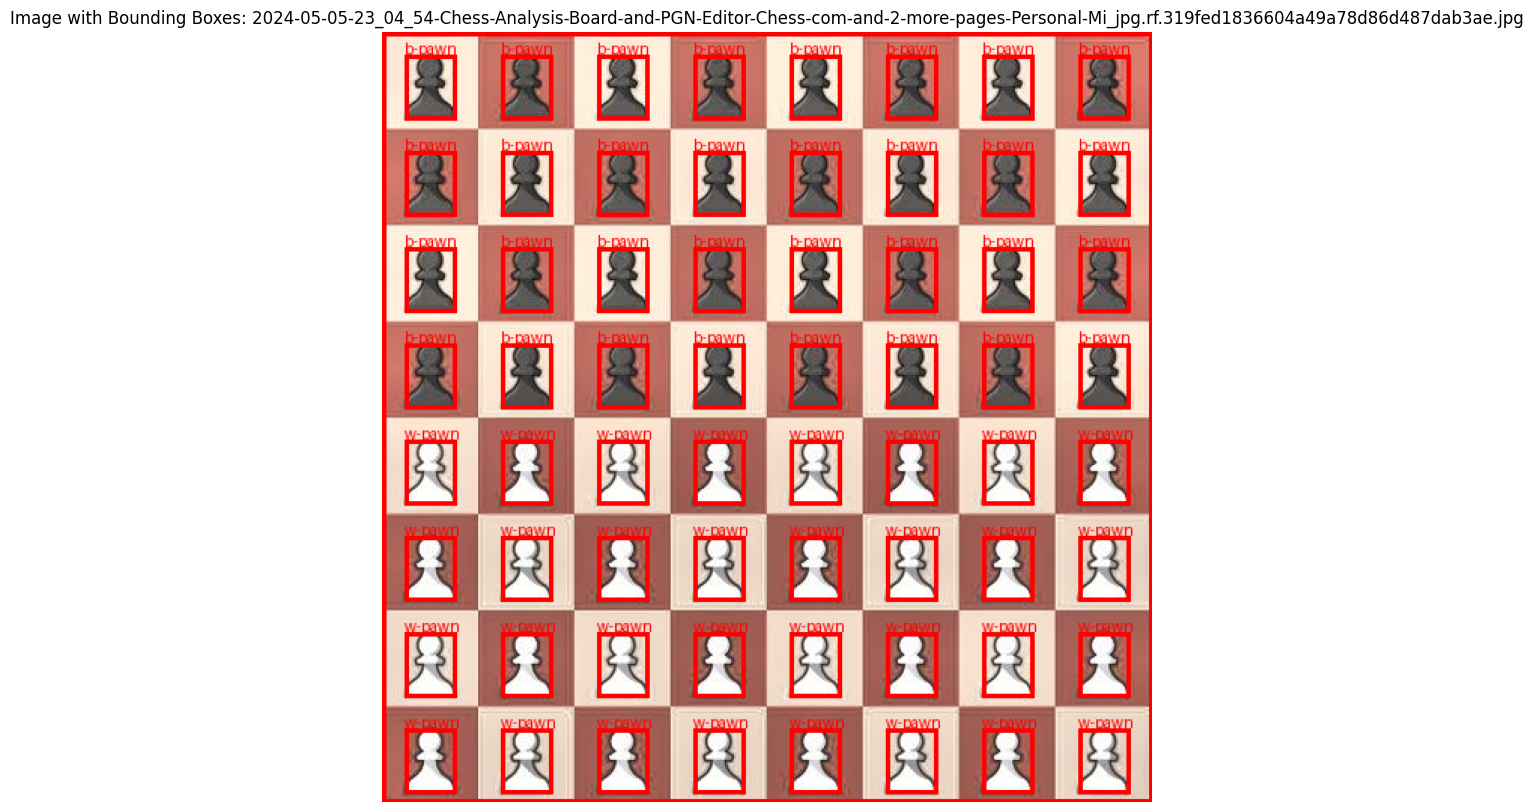

In [ ]:
# Load the COCO annotations
with open(train_annotation_file, 'r') as f:
    coco_data = json.load(f)

# Get a list of images and annotations
images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

# Create a dictionary to map image IDs to their filenames
image_id_to_filename = {img['id']: img['file_name'] for img in images}

# Create a dictionary to map category IDs to their names
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Select the first image for demonstration
if images:
    selected_image_info = images[10]
    selected_image_filename = selected_image_info['file_name']
    selected_image_id = selected_image_info['id']
    image_filepath = os.path.join(train_images_path, selected_image_filename)

    print(f"Displaying image: {selected_image_filename}")

    # Load the image
    try:
        image = Image.open(image_filepath).convert("RGB")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_filepath}")
        exit()

    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Iterate through annotations to find those belonging to the selected image
    for ann in annotations:
        if ann['image_id'] == selected_image_id:
            # Bounding box format is [x, y, width, height]
            x, y, w, h = ann['bbox']
            # Draw the rectangle (x_min, y_min, x_max, y_max)
            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

            # Optionally, add category label
            category_name = category_id_to_name.get(ann['category_id'], 'Unknown')
            draw.text((x, y - 10), category_name, fill="red") # Adjust position for visibility

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off') # Hide axes
    plt.title(f'Image with Bounding Boxes: {selected_image_filename}')
    plt.show()
else:
    print("No images found in the annotations.")

In [ ]:
# Load the COCO annotations for the training dataset (which is now updated)
with open(train_annotation_file, 'r') as f:
    coco_data = json.load(f)

# Determine the amount of classes from the updated coco_data
categories = coco_data['categories']
num_classes = len(categories)

# for each class print out the class name
print(f"Number of unique classes: {num_classes}")
for category_item in categories:
    print(f"ID: {category_item['id']}, Name: {category_item['name']}")


Number of unique classes: 13
ID: 1, Name: b-bishop
ID: 2, Name: b-king
ID: 3, Name: b-knight
ID: 4, Name: b-pawn
ID: 5, Name: b-queen
ID: 6, Name: b-rook
ID: 7, Name: board
ID: 8, Name: w-bishop
ID: 9, Name: w-king
ID: 10, Name: w-knight
ID: 11, Name: w-pawn
ID: 12, Name: w-queen
ID: 13, Name: w-rook


In [ ]:
# Creeer name -> new_id mapping
unique_names = sorted({cat['name'] for cat in coco_data['categories']})
name_to_id = {name: i+1 for i, name in enumerate(unique_names)}

# Pas annotations aan
for ann in coco_data['annotations']:
    old_cat_id = ann['category_id']
    cat_name = next(c['name'] for c in coco_data['categories'] if c['id'] == old_cat_id)
    ann['category_id'] = name_to_id[cat_name]

# Maak nieuwe categories lijst
coco_data['categories'] = [{"id": i, "name": n} for n, i in name_to_id.items()]


In [ ]:
# print the adjusted categories data
for i, category_item in enumerate(coco_data['categories']): # Use enumerate to get both index and dictionary
    print(i, category_item)

0 {'id': 1, 'name': 'b-bishop'}
1 {'id': 2, 'name': 'b-king'}
2 {'id': 3, 'name': 'b-knight'}
3 {'id': 4, 'name': 'b-pawn'}
4 {'id': 5, 'name': 'b-queen'}
5 {'id': 6, 'name': 'b-rook'}
6 {'id': 7, 'name': 'board'}
7 {'id': 8, 'name': 'w-bishop'}
8 {'id': 9, 'name': 'w-king'}
9 {'id': 10, 'name': 'w-knight'}
10 {'id': 11, 'name': 'w-pawn'}
11 {'id': 12, 'name': 'w-queen'}
12 {'id': 13, 'name': 'w-rook'}


# Import Dependencies Detectron

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.9 ; cuda:  cu126
detectron2: 0.6


In [ ]:
TRAIN_DATASET_NAME = "ChessImages-train"
VAL_DATASET_NAME = "ChessImages-val"
TEST_DATASET_NAME = "ChessImages-test"
dataset_path = dataset.location
MODEL_CONFIG = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" # Changed to a valid model in Detectron2's Model Zoo

In [ ]:
# Helper function to unregister datasets if they exist
def unregister_if_exists(name):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
    if name in MetadataCatalog.list():
        MetadataCatalog.remove(name)

# Unregister existing datasets to avoid AssertionErrors upon re-execution
unregister_if_exists(TRAIN_DATASET_NAME)
unregister_if_exists(VAL_DATASET_NAME)
unregister_if_exists(TEST_DATASET_NAME)

# Register new datasets with updated paths
register_coco_instances(TRAIN_DATASET_NAME, {}, train_annotation_file, train_images_path)
register_coco_instances(VAL_DATASET_NAME, {}, val_annotation_file, val_images_path)
register_coco_instances(TEST_DATASET_NAME, {}, test_annotation_file, test_images_path)

# The detectron2 dataset dicts and dataset metadata can be read from the DatasetCatalog and
# MetadataCatalog, respectively.
train_metadata = MetadataCatalog.get(TRAIN_DATASET_NAME)
val_metadata = MetadataCatalog.get(VAL_DATASET_NAME)
test_metadata = MetadataCatalog.get(TEST_DATASET_NAME)

train_dicts = DatasetCatalog.get(TRAIN_DATASET_NAME)
val_dicts = DatasetCatalog.get(VAL_DATASET_NAME)
test_dicts = DatasetCatalog.get(TEST_DATASET_NAME)

[01/20 08:01:10 d2.data.datasets.coco]: Loaded 159 images in COCO format from /content/chess-piece-detection_board-6/train/_annotations.coco.json
[01/20 08:01:10 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/chess-piece-detection_board-6/valid/_annotations.coco.json
[01/20 08:01:10 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/chess-piece-detection_board-6/test/_annotations.coco.json


# Training of detectron 2 on chess pieces
fine-tune a COCO-pretrained faster R-CNN model on the ChessImages dataset

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader
# Removed 'Grayscale' as it's not directly importable in your environment.
from detectron2.data.transforms import ResizeShortestEdge, RandomFlip, RandomApply
from detectron2.data.datasets.coco import load_coco_json
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T # Import as T for custom transform base
import cv2 # Needed for grayscale conversion
import numpy as np # Needed for type hinting in custom transform

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(MODEL_CONFIG)) #select config from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_CONFIG)  #select model from model zoo

cfg.DATASETS.TRAIN = (TRAIN_DATASET_NAME,)
cfg.DATASETS.TEST = (VAL_DATASET_NAME,) # Use VAL_DATASET_NAME for testing/evaluation

cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.MAX_ITER = 3000

cfg.SOLVER.IMS_PER_BATCH = 2  # batch size

cfg.SOLVER.BASE_LR = 0.005  # learning rate

cfg.SOLVER.STEPS = [1000, 1500, 2000, 2500] # learning rate decay

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size".

# Dynamically set based on registered dataset, now using the corrected num_classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True

cfg.TEST.EVAL_PERIOD = 500

print(cfg)


CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('ChessImages-val',)
  TRAIN: ('ChessImages-train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
 

In [ ]:
# COCOTrainer implementation for intermediate evaluation of the detector
class COCOTrainer(DefaultTrainer):
    """
    Custom Trainer that uses COCOEvaluator for evaluation.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create a COCOEvaluator for the given dataset.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_eval")
        os.makedirs(output_folder, exist_ok=True)

        # COCOEvaluator works for instance detection/segmentation/keypoints
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# Training of the detector
trainer = COCOTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/20 08:01:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 193MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/20 08:01:12 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
W0120 08:01:15.638000 606 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


[01/20 08:01:18 d2.utils.events]:  eta: 0:03:39  iter: 19  total_loss: 3.87  loss_cls: 2.817  loss_box_reg: 0.6055  loss_rpn_cls: 0.3407  loss_rpn_loc: 0.09443    time: 0.0849  last_time: 0.0708  data_time: 0.0105  last_data_time: 0.0036   lr: 1.4405e-05  max_mem: 1622M
[01/20 08:01:25 d2.utils.events]:  eta: 0:03:37  iter: 39  total_loss: 3.269  loss_cls: 2.491  loss_box_reg: 0.6336  loss_rpn_cls: 0.03388  loss_rpn_loc: 0.1071    time: 0.0850  last_time: 0.0715  data_time: 0.0039  last_data_time: 0.0037   lr: 2.4305e-05  max_mem: 1622M
[01/20 08:01:26 d2.utils.events]:  eta: 0:03:33  iter: 59  total_loss: 2.861  loss_cls: 2.047  loss_box_reg: 0.6524  loss_rpn_cls: 0.03592  loss_rpn_loc: 0.1057    time: 0.0801  last_time: 0.0714  data_time: 0.0039  last_data_time: 0.0039   lr: 3.4205e-05  max_mem: 1622M
[01/20 08:01:28 d2.utils.events]:  eta: 0:03:29  iter: 79  total_loss: 2.241  loss_cls: 1.43  loss_box_reg: 0.6642  loss_rpn_cls: 0.02806  loss_rpn_loc: 0.1207    time: 0.0777  last_tim

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained

In [ ]:
from google.colab import drive
import torch
import os

drive.mount('/content/drive')
weights_path = '/content/drive/MyDrive/AI@HomePro/ChessModels/model_mergeDatasets_bias.pth'
#torch.save(trainer.state_dict(), weights_path)
torch.save(trainer.model.state_dict(), weights_path)

Mounted at /content/drive


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = weights_path  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # The neural network needs to be 80% sure before assigning the class.
cfg.MODEL.ROI_HEADS.NMS_THRESH = 0.3 # Compare the Intersection of Union between multiple boxes that belong to the same class.
predictor = DefaultPredictor(cfg)

[01/20 08:05:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AI@HomePro/ChessModels/model_mergeDatasets_bias.pth ...


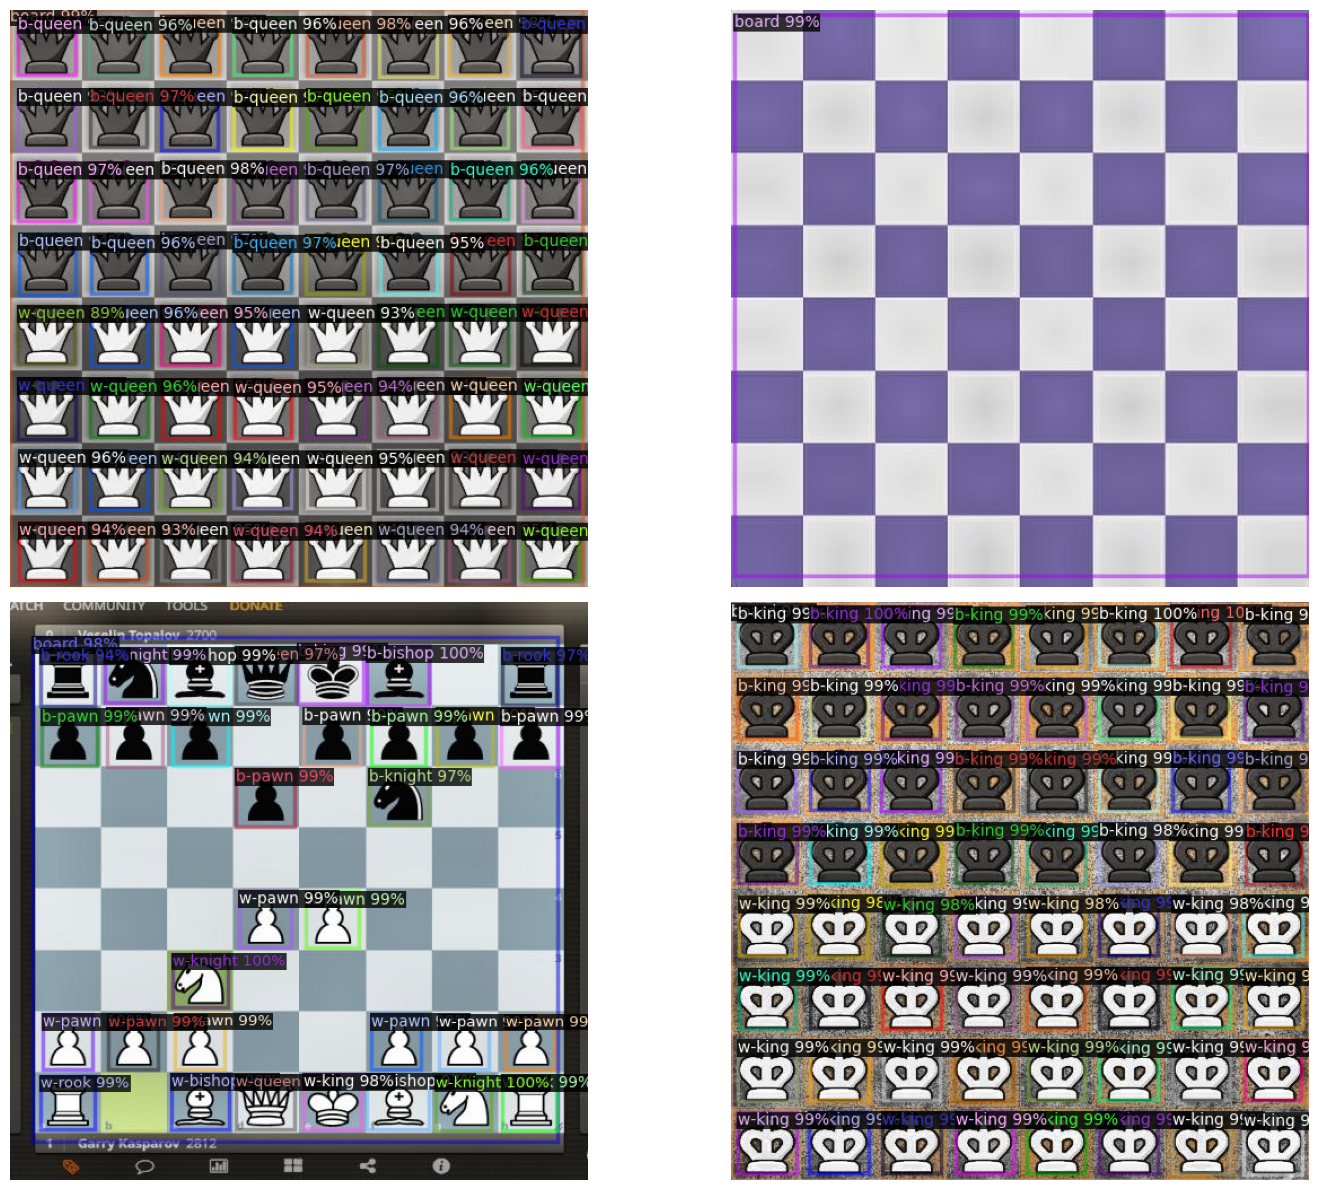

In [ ]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import random
import cv2

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, d in zip(axes, random.sample(val_dicts, 4)):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    v = Visualizer(
        im[:, :, ::-1],
        metadata=val_metadata,
        scale=1.0,
        instance_mode=None
    )

    out = v.draw_instance_predictions(
        outputs["instances"].to("cpu")
    )

    ax.imshow(out.get_image())
    ax.axis("off")

plt.tight_layout()
plt.show()

- AP	Average precision across IoU thresholds from 0.50 → 0.95 (step 0.05). This is the main COCO score.
- AP50	AP at IoU = 0.50 ("easier" detections).
- AP75	AP at IoU = 0.75 ("stricter" matching).
- AP_small	AP for small objects.
- AP_medium	AP for medium objects.
- AP_large	AP for large objects.

In [ ]:
evaluator = COCOEvaluator(VAL_DATASET_NAME, output_dir=cfg.OUTPUT_DIR)

test_loader = build_detection_test_loader(cfg, VAL_DATASET_NAME)

print(inference_on_dataset(predictor.model, test_loader, evaluator))

[01/20 08:05:39 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/chess-piece-detection_board-6/valid/_annotations.coco.json
[01/20 08:05:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 08:05:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/20 08:05:39 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/20 08:05:39 d2.data.common]: Serialized dataset takes 0.08 MiB
[01/20 08:05:39 d2.evaluation.evaluator]: Start inference on 40 batches
[01/20 08:05:40 d2.evaluation.evaluator]: Inference done 11/40. Dataloading: 0.0010 s/iter. Inference: 0.0255 s/iter. Eval: 0.0003 s/iter. Total: 0.0268 s/iter. ETA=0:00:00
[01/20 08:05:41 d2.evaluation.evaluator]: Total inference time: 0:00:00.967918 (0.027655 s / iter per device, on 1 devices)
[01/20 08:05:41 d2

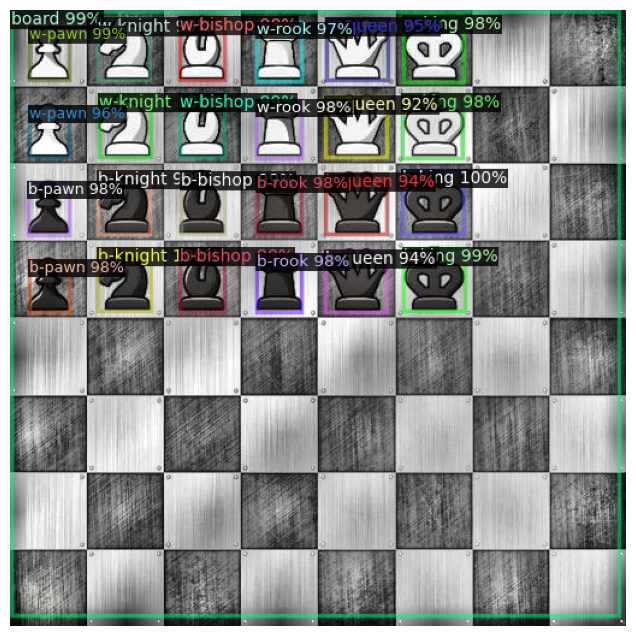

In [ ]:
image_input = test_dicts[0]["file_name"]

im = cv2.imread(image_input)
outputs = predictor(im)

v = Visualizer(
    im[:, :, ::-1],
    metadata=val_metadata,
    scale=1.0
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(8, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()